In [1]:
import os
import numpy as np
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F

train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.Resize(250),
                                      transforms.RandomCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])
                                     ])

test_transform = transforms.Compose([transforms.Resize(250),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], 
                                                          [0.229, 0.224, 0.225])
                                    ])


data_dir = 'dogImages/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=test_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

print('Num Training imgs: ', len(train_data))
print('Num Validation imgs: ', len(valid_data))
print('Num Test imgs: ', len(test_data))

batch_size = 8
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)


loaders_scratch = {'train': train_loader, 
                   'valid': valid_loader, 
                   'test': test_loader}

classes = train_data.classes

Num Training imgs:  6680
Num Validation imgs:  835
Num Test imgs:  836


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


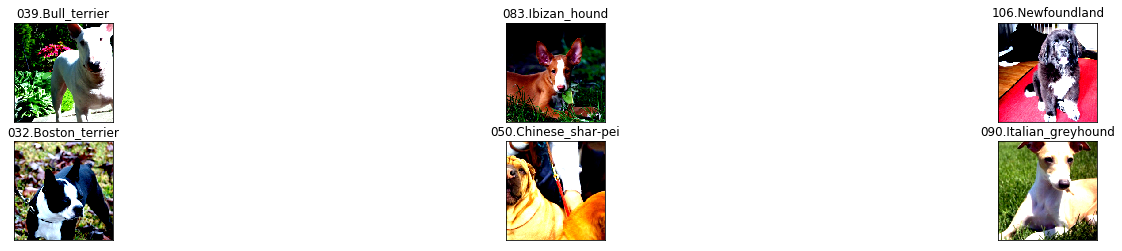

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
fig = plt.figure(figsize=(25,4))
for idx in np.arange(6):
    ax = fig.add_subplot(2, 6/2, idx+1, xticks=[], yticks=[])
    images[idx] = images[idx]/2 +0.5
    plt.imshow(np.transpose(images[idx], (1,2,0)))
    ax.set_title(classes[labels[idx]])
    

## Architecture 1: 
##### 5 Conv Layers: 32 to 512 channels - all with 3x3 kernels, stride=1 and padding=1
##### Batch Normalization and ReLU activation on each Convolutional Layer
##### MaxPool(2,2) after each Convolutional Layer
##### 3 fully connected layers with ReLU applied to fc1 and fc2
##### Dropout with probability of 50% applied after 2nd, 3rd, and 4th convolutional layer (before maxpool layers)
##### Dropout with probability of 50% applied after 1st fc layer layer only
##### CrossEntropyLoss (applied as log_softmax on 3rd fc layer and NLLLoss as criterion
##### Adam optimizer with lr=0.0025

###### Result: after 10 training epochs: 
Epoch: 1 	Training Loss: 5.363417 	Validation Loss: 4.876212

Epoch: 2 	Training Loss: 4.888124 	Validation Loss: 4.870528

Epoch: 3 	Training Loss: 4.909029 	Validation Loss: 4.868946

Epoch: 4 	Training Loss: 4.878525 	Validation Loss: 4.867552

Epoch: 5 	Training Loss: 4.878072 	Validation Loss: 4.867843

Epoch: 6 	Training Loss: 4.872267 	Validation Loss: 4.868251

Epoch: 7 	Training Loss: 4.866718 	Validation Loss: 4.868318

Epoch: 8 	Training Loss: 4.867238 	Validation Loss: 4.867780

Epoch: 9 	Training Loss: 4.866567 	Validation Loss: 4.868664

Epoch: 10 	Training Loss: 4.866593 	Validation Loss: 4.868259

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.batchnorm4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, 3, padding=1)
        self.batchnorm5 = nn.BatchNorm2d(512)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(512*7*7, 1000, bias=True)
        self.fc2 = nn.Linear(1000, 500, bias=True)
        self.fc3 = nn.Linear(500, 133, bias=True)
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.batchnorm2(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(x)
        x = F.relu(self.batchnorm3(self.conv3(x)))
        x = self.dropout(x)
        x = self.pool(x)
        x = F.relu(self.batchnorm4(self.conv4(x)))
        x = self.dropout(x)
        x = self.pool(x)
        x = F.relu(self.batchnorm5(self.conv5(x)))
        x = self.pool(x)
        
        x = x.view(-1, 512*7*7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
use_cuda = torch.cuda.is_available()
if use_cuda:
    model_scratch.cuda()

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.batchnorm4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, 3, padding=1)
        self.batchnorm5 = nn.BatchNorm2d(512)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(512*7*7, 1000, bias=True)
        self.fc2 = nn.Linear(1000, 133, bias=True)
#         self.fc3 = nn.Linear(500, 133, bias=True)
        self.dropout = nn.Dropout(p=0.3)
        
    def forward(self, x):
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.batchnorm2(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(x)
        x = F.relu(self.batchnorm3(self.conv3(x)))
        x = self.dropout(x)
        x = self.pool(x)
        x = F.relu(self.batchnorm4(self.conv4(x)))
        x = self.dropout(x)
        x = self.pool(x)
        x = F.relu(self.batchnorm5(self.conv5(x)))
        x = self.pool(x)
        
        x = x.view(-1, 512*7*7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
use_cuda = torch.cuda.is_available()
if use_cuda:
    model_scratch.cuda()

In [5]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss

### TODO: select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.0025)

In [8]:
# from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True

# valid_loss_min = np.Inf

# epochs = 5
# for e in range(epochs):
#     running_loss = 0.0
#     for images, labels in train_loader:
#         images, labels = images.cuda(), labels.cuda()
#         optimizer_scratch.zero_grad()
#         output = model_scratch(images)
#         loss = criterion_scratch(output, labels)
#         loss.backward()
#         optimizer_scratch.step()
#         running_loss += loss.item()
#     else:
#         print("Training loss: {:.6f}".format(running_loss/len(train_loader)))



Training loss: 9.782534
Training loss: 5.036802
Training loss: 4.944024
Training loss: 4.900999
Training loss: 5.088080


In [13]:

# import matplotlib.pyplot as plt
# %matplotlib inline
# images, labels = next(iter(train_loader))
# images, labels = images.cuda(), labels.cuda()
# with torch.no_grad():
#     logps = model_scratch(images)
# probs = torch.exp(logps)


In [15]:
# print(images[0])

tensor([[[ 0.6000,  0.6000,  0.6078,  ...,  0.5843,  0.5686,  0.5608],
         [ 0.6078,  0.6078,  0.6078,  ...,  0.5765,  0.5608,  0.5608],
         [ 0.6235,  0.6157,  0.6078,  ...,  0.5686,  0.5608,  0.5765],
         ...,
         [-0.0980, -0.2392, -0.4196,  ...,  0.0824, -0.3333, -0.4118],
         [-0.1216, -0.5294, -0.5059,  ...,  0.0667, -0.3020, -0.5608],
         [-0.0588,  0.0275, -0.0275,  ..., -0.0118, -0.2314,  0.2706]],

        [[ 0.6078,  0.6078,  0.6078,  ...,  0.5843,  0.5686,  0.5608],
         [ 0.6157,  0.6157,  0.6078,  ...,  0.5765,  0.5608,  0.5608],
         [ 0.6235,  0.6235,  0.6078,  ...,  0.5686,  0.5608,  0.5765],
         ...,
         [-0.1294, -0.2392, -0.3490,  ...,  0.1216, -0.3098, -0.3961],
         [-0.1451, -0.5294, -0.4588,  ...,  0.0980, -0.2941, -0.5608],
         [-0.0824,  0.0275,  0.0196,  ..., -0.0039, -0.2314,  0.2627]],

        [[ 0.6549,  0.6627,  0.6863,  ...,  0.6784,  0.6627,  0.6549],
         [ 0.6549,  0.6627,  0.6863,  ...,  0

In [19]:
# print(images[0][0])
# print(images[0][1])
# print(images[1][0])

tensor([[ 0.6000,  0.6000,  0.6078,  ...,  0.5843,  0.5686,  0.5608],
        [ 0.6078,  0.6078,  0.6078,  ...,  0.5765,  0.5608,  0.5608],
        [ 0.6235,  0.6157,  0.6078,  ...,  0.5686,  0.5608,  0.5765],
        ...,
        [-0.0980, -0.2392, -0.4196,  ...,  0.0824, -0.3333, -0.4118],
        [-0.1216, -0.5294, -0.5059,  ...,  0.0667, -0.3020, -0.5608],
        [-0.0588,  0.0275, -0.0275,  ..., -0.0118, -0.2314,  0.2706]],
       device='cuda:0')
tensor([[ 0.6078,  0.6078,  0.6078,  ...,  0.5843,  0.5686,  0.5608],
        [ 0.6157,  0.6157,  0.6078,  ...,  0.5765,  0.5608,  0.5608],
        [ 0.6235,  0.6235,  0.6078,  ...,  0.5686,  0.5608,  0.5765],
        ...,
        [-0.1294, -0.2392, -0.3490,  ...,  0.1216, -0.3098, -0.3961],
        [-0.1451, -0.5294, -0.4588,  ...,  0.0980, -0.2941, -0.5608],
        [-0.0824,  0.0275,  0.0196,  ..., -0.0039, -0.2314,  0.2627]],
       device='cuda:0')
tensor([[-0.0353, -0.0196,  0.0039,  ..., -0.7961, -0.7882, -0.7882],
        [-0.03

In [6]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):

        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            optimizer.zero_grad()
            output = model(data)  #output is tensor of shape([batch_size, num_classes]) where largest value is the prediction
            loss = criterion(output, target) # loss is the cross-entropy loss which measures how far the prediction is from the actual target
            loss.backward()  # calculating the gradients for all operations
            optimizer.step() #performing gradient descent step
            train_loss += loss.item()

    
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            with torch.no_grad():
                output = model(data)
                loss = criterion(output, target)
                valid_loss += loss.item()
            
        train_loss = train_loss / len(train_loader)
        valid_loss = valid_loss / len(valid_loader)
        
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation Loss Decreased. Saving model')
            torch.save(model.state_dict(), 'model_scratch.pt')
            valid_loss_min = valid_loss
    # return trained model
    return model



In [7]:
# train the model
model_scratch = train(10, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')



Epoch: 1 	Training Loss: 5.363417 	Validation Loss: 4.876212
True
Validation Loss Decreased. Saving model
Epoch: 2 	Training Loss: 4.888124 	Validation Loss: 4.870528
True
Validation Loss Decreased. Saving model
Epoch: 3 	Training Loss: 4.909029 	Validation Loss: 4.868946
True
Validation Loss Decreased. Saving model
Epoch: 4 	Training Loss: 4.878525 	Validation Loss: 4.867552
True
Validation Loss Decreased. Saving model
Epoch: 5 	Training Loss: 4.878072 	Validation Loss: 4.867843
True
Epoch: 6 	Training Loss: 4.872267 	Validation Loss: 4.868251
True
Epoch: 7 	Training Loss: 4.866718 	Validation Loss: 4.868318
True
Epoch: 8 	Training Loss: 4.867238 	Validation Loss: 4.867780
True
Epoch: 9 	Training Loss: 4.866567 	Validation Loss: 4.868664
True
Epoch: 10 	Training Loss: 4.866593 	Validation Loss: 4.868259
True


In [ ]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

In [ ]:
def test(model, )
    for batch_idx, (data, target) in enumerate(test_loader):
        if use_cuda():
            data, target = data.cuda(), target.cuda()
        output = model_scratch(data)

In [9]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):

        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        if use_cuda:
            model = model.cuda()
        ###################
        # train the model #
        ###################
        model.train()
        for p in model.parameters():
            p.requires_grad=True
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            optimizer.zero_grad()
            output = model(data)  #output is tensor of shape([batch_size, num_classes]) where largest value is the prediction
            

            
            
            loss = criterion(output, target) # loss is the cross-entropy loss which measures how far the prediction is from the actual target
            loss.backward()  # calculating the gradients for all operations
            optimizer.step() #performing gradient descent step
            
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            train_loss = train_loss + ((1 / (batch_idx+1))*(loss.data-train_loss))
           
            
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            with torch.no_grad():
                output = model(data)
                loss = criterion(output, target)
                valid_loss = valid_loss + ((1/(batch_idx+1))*(loss.data-valid_loss))
        
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation Loss Decreased. Saving model')
            torch.save(model.state_dict(), 'model_scratch.pt')
            valid_loss_min = valid_loss
    # return trained model
    return model


# train the model
model_scratch = train(30, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 8.555840 	Validation Loss: 4.883201
Validation Loss Decreased. Saving model


KeyboardInterrupt: 